# Data Merge

#### 0. Load Data
Load raw data and required packages.

In [1]:
import pandas as pd
import numpy as np
import mpu
import json
import re  
import geopandas as gpd
import folium
import pygeos
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

house = pd.read_csv('../data/house_combined.csv')
bus = pd.read_csv('../data/bus_stops_file.csv')
train = pd.read_csv('../data/train_stops_file.csv')
tram = pd.read_csv('../data/tram_stops_file.csv')
vline = pd.read_csv('../data/vline_stops_file.csv')
# population = pd.read_excel('../data/Population.xlsx')
# income = pd.read_excel('../data/Income.xlsx',sheet_name="Forecasted Income")
# male = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Male")
# female = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Female")
school = pd.read_csv('../data/school.csv',sep=",", encoding='cp1252')
hospital = pd.read_csv('../data/hospital_csv',sep=",", encoding='cp1252')
sc = pd.read_csv('../data/shopping_with_postcode.csv')
data_2019 = pd.read_csv('../data/2019_data.csv',sep=",", encoding='cp1252')
data_2020 = pd.read_csv('../data/2020_data.csv',sep=",", encoding='cp1252')
data_2021 = pd.read_csv('../data/2021_data.csv',sep=",", encoding='cp1252')
data_2022 = pd.read_csv('../data/2022_data.csv',sep=",", encoding='cp1252')
data_2022 = pd.read_csv('../data/2022_data.csv',sep=",", encoding='cp1252')

/home/lzy/miniconda3/envs/ads/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


#### 1. Property

1.1 Extract needed columns 

In [2]:

need_col = [
    "Unnamed: 0",
    "propertyTypes",
    "bathrooms",
    "bedrooms",
    "carspaces",
    "dateUpdated",
    "dateListed",
    "geoLocation",
    "landAreaSqm",
    "postcode",
    "surburb",
    'year', 
    'month',
    'price', 
    'bond',
    'rent'
]

init_house = house[need_col]
init_house.rename(columns={"Unnamed: 0":"index"}, inplace=True)
init_house["geoLocation"] = init_house["geoLocation"].apply(lambda x: re.sub('\'','\"', str(x)))
init_house = init_house[init_house["geoLocation"] != 'nan']
init_house['longitude'] = init_house['geoLocation'].apply(lambda d: json.loads(d)["longitude"])
init_house['latitude'] = init_house['geoLocation'].apply(lambda d: json.loads(d)["latitude"])

1.2 Add in SA2 code for later join

In [3]:
df =  gpd.read_file("../data/SA2 ERP GeoPackage 2021 (ASGS2021).gpkg")
# df

In [4]:
df = df[(df['State_name_2021'] == 'Victoria' )]
df = df[['SA2_maincode_2021','geometry']]

In [5]:
datashp = gpd.GeoDataFrame(init_house, geometry=gpd.points_from_xy(init_house.longitude,init_house.latitude))

In [6]:
init_house = gpd.sjoin(datashp, df, how='inner', op='intersects')

#### 2. Transportation

##### 2.1 Bus

In [7]:
# Bus
merge_bus = pd.merge(init_house,bus,how='left',on='postcode')
merge_bus["tmp"] = np.sin(merge_bus["stop_latitude"] - merge_bus["latitude"] / 2)**2 + np.cos(merge_bus["latitude"]) * np.cos(merge_bus["stop_latitude"]) * np.sin(merge_bus["stop_longitude"] - merge_bus["longitude"] / 2)**2
merge_bus["bus_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_bus["tmp"]), np.sqrt(1 - merge_bus["tmp"]))


In [8]:
bus_stop_min = pd.DataFrame(merge_bus.groupby(["index",'postcode'])["bus_stop_distance"].min())
# bus_stop_min
bus_stop_count = pd.DataFrame(merge_bus.groupby(["index",'postcode'])["bus_stop_distance"].count())
# bus_stop_count
init_house = pd.merge(init_house,bus_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,bus_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"bus_stop_distance_x":"distance of the closest bus stop","bus_stop_distance_y":"count of bus stop"}, inplace=True)
# init_house

##### 2.2 Train

In [9]:
merge_train = pd.merge(init_house,train,how='left',on='postcode')
merge_train["tmp"] = np.sin(merge_train["stop_latitude"] - merge_train["latitude"] / 2)**2 + np.cos(merge_train["latitude"]) * np.cos(merge_train["stop_latitude"]) * np.sin(merge_train["stop_longitude"] - merge_train["longitude"] / 2)**2
merge_train["train_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_train["tmp"]), np.sqrt(1 - merge_train["tmp"]))
train_stop_min = pd.DataFrame(merge_train.groupby(["index",'postcode'])["train_stop_distance"].min())
train_stop_count = pd.DataFrame(merge_train.groupby(["index",'postcode'])["train_stop_distance"].count())
init_house = pd.merge(init_house,train_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,train_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"train_stop_distance_x":"distance of the closest train stop","train_stop_distance_y":"count of train stop"}, inplace=True)


##### 2.3 Tram

In [10]:
merge_tram = pd.merge(init_house,tram,how='left',on='postcode')
merge_tram["tmp"] = np.sin(merge_tram["stop_latitude"] - merge_tram["latitude"] / 2)**2 + np.cos(merge_tram["latitude"]) * np.cos(merge_tram["stop_latitude"]) * np.sin(merge_tram["stop_longitude"] - merge_tram["longitude"] / 2)**2
merge_tram["tram_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_tram["tmp"]), np.sqrt(1 - merge_tram["tmp"]))
tram_stop_min = pd.DataFrame(merge_tram.groupby(["index",'postcode'])["tram_stop_distance"].min())
tram_stop_count = pd.DataFrame(merge_tram.groupby(["index",'postcode'])["tram_stop_distance"].count())
init_house = pd.merge(init_house,tram_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,tram_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"tram_stop_distance_x":"distance of the closest tram stop","tram_stop_distance_y":"count of tram stop"}, inplace=True)

##### 2.4 Vline

In [11]:
merge_vline = pd.merge(init_house,vline,how='left',on='postcode')
merge_vline["tmp"] = np.sin(merge_vline["stop_latitude"] - merge_vline["latitude"] / 2)**2 + np.cos(merge_vline["latitude"]) * np.cos(merge_vline["stop_latitude"]) * np.sin(merge_vline["stop_longitude"] - merge_vline["longitude"] / 2)**2
merge_vline["vline_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_vline["tmp"]), np.sqrt(1 - merge_vline["tmp"]))
vline_stop_min = pd.DataFrame(merge_vline.groupby(["index",'postcode'])["vline_stop_distance"].min())
vline_stop_count = pd.DataFrame(merge_vline.groupby(["index",'postcode'])["vline_stop_distance"].count())
init_house = pd.merge(init_house,vline_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,vline_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"vline_stop_distance_x":"distance of the closest vline stop","vline_stop_distance_y":"count of vline stop"}, inplace=True)

#### 3. Facilities

##### 3.1 School

In [12]:
merge_school = pd.merge(init_house,school,how='left',left_on='postcode',right_on="Address_Postcode")
merge_school["tmp"] = np.sin(merge_school["Y"] - merge_school["latitude"] / 2)**2 + np.cos(merge_school["latitude"]) * np.cos(merge_school["Y"]) * np.sin(merge_school["X"] - merge_school["longitude"] / 2)**2
merge_school["school_distance"] = 2 * np.arctan2(np.sqrt(merge_school["tmp"]), np.sqrt(1 - merge_school["tmp"]))
school_stop_min = pd.DataFrame(merge_school.groupby(["index",'Address_Postcode'])["school_distance"].min())
school_stop_count = pd.DataFrame(merge_school.groupby(["index",'Address_Postcode'])["school_distance"].count())
init_house = pd.merge(init_house,school_stop_min,how='left',left_on=['index','postcode'],right_on=['index','Address_Postcode'])
init_house = pd.merge(init_house,school_stop_count,how='left',left_on=['index','postcode'],right_on=['index','Address_Postcode'])
init_house.rename(columns={"school_distance_x":"distance of the closest school","school_distance_y":"count of school"}, inplace=True)

##### 3.2 Hospital

In [13]:
merge_hospital = pd.merge(init_house,hospital,how='left',on='postcode')
merge_hospital
hospital_count = pd.DataFrame(merge_hospital.groupby(["index",'postcode'])["name"].count())
hospital_count
init_house = pd.merge(init_house,hospital_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"name":"count of hospital"}, inplace=True)

##### 3.3 Shopping Center/Malls

In [14]:
# get lat & lon from shopping center data file
a = sc['Location'].str.split(",",n = 1, expand = True)
sc['stop_longitude']=a[1]
b = a[0].str.split(":",n = 1, expand = True)
sc['stop_latitude']=b[1]

# update data type for lat and long extracted
sc = sc.astype({'stop_longitude': 'float'})
sc = sc.astype({'stop_latitude': 'float'})
# sc.dtypes


In [15]:
merge_sc = pd.merge(init_house, sc, how='left',on='postcode')
merge_sc
merge_sc["tmp"] = np.sin(merge_sc["stop_latitude"] - merge_sc["latitude"] / 2)**2 + np.cos(merge_sc["latitude"]) * np.cos(merge_sc["stop_latitude"]) * np.sin(merge_sc["stop_longitude"] - merge_sc["longitude"] / 2)**2
merge_sc["sc_distance"] = 2 * np.arctan2(np.sqrt(merge_sc["tmp"]), np.sqrt(1 - merge_sc["tmp"]))
sc_stop_min = pd.DataFrame(merge_sc.groupby(["index",'postcode'])["sc_distance"].min())
sc_stop_count = pd.DataFrame(merge_sc.groupby(["index",'postcode'])["sc_distance"].count())
init_house = pd.merge(init_house,sc_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,sc_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"sc_distance_x":"distance to the closest shopping mall","sc_distance_y":"count of shopping mall"}, inplace=True)
init_house.head(5)


,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,count of tram stop,distance of the closest vline stop,count of vline stop,distance of the closest school,count of school,count of hospital,distance to the closest shopping mall,count of shopping mall
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,0.436505,10,NaN,0,0.438447,24,NaN,0,0.441059,3.0,0,NaN,0
1,9,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,0.432419,10,NaN,0,0.434362,24,NaN,0,0.436974,3.0,0,NaN,0
2,10,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,0.434637,10,NaN,0,0.436558,24,NaN,0,0.439169,3.0,0,NaN,0
3,11,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,0.443168,10,NaN,0,0.445094,24,NaN,0,0.447706,3.0,0,NaN,0
4,21,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,0.446094,10,NaN,0,0.448013,24,NaN,0,0.450625,3.0,0,NaN,0


Checking correlation heatmap between current feature.

<AxesSubplot:>

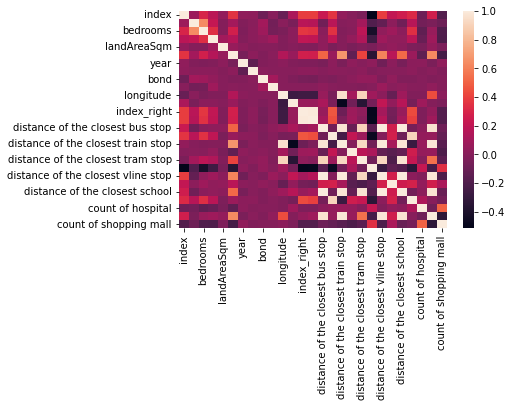

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = init_house.corr()
sns.heatmap(corr)

In [17]:
# Save merged data table to curated folder
# init_house.to_csv("../data/curated/init_house.csv")

#### 4. ABS Data: Population, income and Sex

##### 4.1 Data Reload

4.1.1 Population

In [18]:
population = pd.read_excel('../data/Population.xlsx', sheet_name="Pop", header=[0,1])
population.head(3)

Unnamed: 0_level_0 Unnamed: 1_level_0 Population                 \
            SA2 code           SA2 name        2019   2020   2021   
0          201011001          Alfredton       14408  15472  16823   
1          201011002           Ballarat       12311  12183  12076   
2          201011005          Buninyong        7452   7369   7232   

                Population Increase                                
           2022                2019      2020      2021      2022  
0  18044.196846            0.065680  0.073848  0.087319  0.072591  
1  12031.700652            0.006047 -0.010397 -0.008783 -0.003668  
2   7216.773205            0.005261 -0.011138 -0.018591 -0.002105

4.1.1 Income

In [19]:
income = pd.read_excel('../data/Income.xlsx',sheet_name="Forecasted Income", header=[0,1])
income.head(3)

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Earners (persons)  \
                 SA2           SA2 NAME           Postcode              2019   
0          201011001          Alfredton             3350.0       8503.447540   
1          201011002           Ballarat             3350.0       7673.610510   
2          201011003   Ballarat - North             3350.0      13887.614446   

                                            Median age of earners (years)  \
           2020          2021          2022                          2019   
0   9019.555013   9567.571661  10148.885100                     42.000000   
1   7743.676448   7813.745816   7813.745816                     47.516546   
2  14253.732963  14617.249150  14617.249150                     43.000000   

                                        Sum ($)                              \
        2020      2021       2022          2019          2020          2021   
0  42.000000  42.00000  42.000000  5.581284e+08  6.112807e+08  6.684159e+08   
1  47.744301  48.03036  48.390075  6.203439e+08  6.428705e+08  6.724473e+08   
2  43.000000  43.00000  43.000000  8.662905e+08  9.192677e+08  9.765977e+08   

                   Median ($)                                            \
           2022          2019          2020          2021          2022   
0  7.295697e+08  55374.162543  56981.756185  58628.439829  60284.180114   
1  7.019395e+08  55244.566537  56765.110158  58475.016103  60293.138457   
2  1.027101e+09  52249.545142  53999.918073  56041.662605  57892.944588   

       Mean ($)                                            
           2019          2020          2021          2022  
0  65636.394852  67773.311518  69862.748812  71889.039229  
1  80837.265352  83014.858813  86055.212890  89164.155659  
2  62370.887870  64475.677365  66780.534223  68657.186139

4.1.3 Sex Ratio

In [20]:
sex_ratio = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Ratio", header=[0,1])
sex_ratio.head(3)


Unnamed: 0_level_0   Male                             Female                \
                 SA2   2019   2020   2021          2022   2019   2020   2021   
0          201011001   7077   7590   8238   8827.102822   7331   7882   8585   
1          201011002   5874   5780   5695   5663.004769   6437   6403   6381   
2          201011003  11666  11689  11703  11785.855145  12569  12610  12645   

                Person                             Male Ratio            \
           2022   2019   2020   2021          2022       2019      2020   
0   9217.148629  14408  15472  16823  18044.196846   0.491185  0.490564   
1   6368.892049  12311  12183  12076  12031.700652   0.477134  0.474432   
2  12727.455494  24235  24299  24348  24513.296862   0.481370  0.481049   

                      Female Ratio                                
       2021      2022         2019      2020      2021      2022  
0  0.489687  0.489193     0.508815  0.509436  0.510313  0.510810  
1  0.471597  0.470674     0.522866  0.525568  0.528403  0.529343  
2  0.480655  0.480794     0.518630  0.518951  0.519345  0.519206

##### 4.2 Join All

In [21]:
merge_data = population.merge(income, how="left", left_on= [('Unnamed: 0_level_0', 'SA2 code')], right_on=[(           'Unnamed: 0_level_0',      'SA2')])
merge_data = merge_data.merge(sex_ratio, how="left", left_on= [('Unnamed: 0_level_0', 'SA2 code')], right_on=[('Unnamed: 0_level_0', 'SA2')])
merge_data.drop(columns=["Unnamed: 0_level_0_x", "Unnamed: 1_level_0","Unnamed: 2_level_0","Unnamed: 0_level_0_y"],errors='raise',inplace=True)

In [22]:
merge_data.head(3)

Unnamed: 0_level_0 Population                               \
            SA2 code        2019   2020   2021          2022   
0          201011001       14408  15472  16823  18044.196846   
1          201011002       12311  12183  12076  12031.700652   
2          201011005        7452   7369   7232   7216.773205   

  Population Increase                               Earners (persons)  \
                 2019      2020      2021      2022              2019   
0            0.065680  0.073848  0.087319  0.072591       8503.447540   
1            0.006047 -0.010397 -0.008783 -0.003668       7673.610510   
2            0.005261 -0.011138 -0.018591 -0.002105       4322.973567   

                                          Median age of earners (years)  \
          2020         2021          2022                          2019   
0  9019.555013  9567.571661  10148.885100                     42.000000   
1  7743.676448  7813.745816   7813.745816                     47.516546   
2  4407.512769  4483.031429   4483.031429                     46.255556   

                                         Sum ($)                              \
        2020       2021       2022          2019          2020          2021   
0  42.000000  42.000000  42.000000  5.581284e+08  6.112807e+08  6.684159e+08   
1  47.744301  48.030360  48.390075  6.203439e+08  6.428705e+08  6.724473e+08   
2  46.657079  47.163341  47.541016  2.794734e+08  2.924104e+08  3.049772e+08   

                   Median ($)                                            \
           2022          2019          2020          2021          2022   
0  7.295697e+08  55374.162543  56981.756185  58628.439829  60284.180114   
1  7.019395e+08  55244.566537  56765.110158  58475.016103  60293.138457   
2  3.179211e+08  53825.456103  55531.685800  57244.683920  58912.175016   

       Mean ($)                                              Male          \
           2019          2020          2021          2022    2019    2020   
0  65636.394852  67773.311518  69862.748812  71889.039229  7077.0  7590.0   
1  80837.265352  83014.858813  86055.212890  89164.155659  5874.0  5780.0   
2  64645.372883  66339.339696  68023.775165  69741.827133  3835.0  3737.0   

                        Female                                Person           \
     2021         2022    2019    2020    2021         2022     2019     2020   
0  8238.0  8827.102822  7331.0  7882.0  8585.0  9217.148629  14408.0  15472.0   
1  5695.0  5663.004769  6437.0  6403.0  6381.0  6368.892049  12311.0  12183.0   
2  3587.0  3561.736818  3617.0  3632.0  3645.0  3656.101969   7452.0   7369.0   

                         Male Ratio                                \
      2021          2022       2019      2020      2021      2022   
0  16823.0  18044.196846   0.491185  0.490564  0.489687  0.489193   
1  12076.0  12031.700652   0.477134  0.474432  0.471597  0.470674   
2   7232.0   7216.773205   0.514627  0.507124  0.495990  0.493536   

  Female Ratio                                
          2019      2020      2021      2022  
0     0.508815  0.509436  0.510313  0.510810  
1     0.522866  0.525568  0.528403  0.529343  
2     0.485373  0.492876  0.504010  0.506612

##### 4.3 Add features to main table
1. Create SA2 code mapping on main table using postcode2sa2 data.
2. Merge feature from feature table back to main by SA2

In [23]:
init_house = init_house.merge(merge_data, how="left", left_on=["SA2_maincode_2021"], right_on=[(           'Unnamed: 0_level_0', 'SA2 code')])

In [24]:
# init_house.stack()
# sex_ratio = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Ratio", header=[0,1])
# df_sex =sex_ratio.set_index([('Unnamed: 0_level_0', 'SA2')])
# stacked_sex=df_sex.stack()
# stacked_sex

In [25]:
cols = [
    "Population ",
    "Population Increase",
    "Earners (persons)",
    "Median age of earners (years)",
    "Sum ($)",
    "Median ($)",
    "Mean ($)",
    "Male",
    "Female",
    "Person",
    "Male Ratio",
    "Female Ratio"
]

for i in cols:
    init_house[i] = ""
    for j in range(len(init_house)):
        year = init_house["year"][j]
        key = (i,year) 
        init_house[i][j] = init_house[key][j]
init_house

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,count of tram stop,distance of the closest vline stop,count of vline stop,distance of the closest school,count of school,count of hospital,distance to the closest shopping mall,count of shopping mall,"(Unnamed: 0_level_0, SA2 code)","(Population , 2019)","(Population , 2020)","(Population , 2021)","(Population , 2022)","(Population Increase, 2019)","(Population Increase, 2020)","(Population Increase, 2021)","(Population Increase, 2022)","(Earners (persons), 2019)","(Earners (persons), 2020)","(Earners (persons), 2021)","(Earners (persons), 2022)","(Median age of earners (years), 2019)","(Median age of earners (years), 2020)","(Median age of earners (years), 2021)","(Median age of earners (years), 2022)","(Sum ($), 2019)","(Sum ($), 2020)","(Sum ($), 2021)","(Sum ($), 2022)","(Median ($), 2019)","(Median ($), 2020)","(Median ($), 2021)","(Median ($), 2022)","(Mean ($), 2019)","(Mean ($), 2020)","(Mean ($), 2021)","(Mean ($), 2022)","(Male, 2019)","(Male, 2020)","(Male, 2021)","(Male, 2022)","(Female, 2019)","(Female, 2020)","(Female, 2021)","(Female, 2022)","(Person, 2019)","(Person, 2020)","(Person, 2021)","(Person, 2022)","(Male Ratio, 2019)","(Male Ratio, 2020)","(Male Ratio, 2021)","(Male Ratio, 2022)","(Female Ratio, 2019)","(Female Ratio, 2020)","(Female Ratio, 2021)","(Female Ratio, 2022)",Population,Population Increase,Earners (persons),Median age of earners (years),Sum ($),Median ($),Mean ($),Male,Female,Person,Male Ratio,Female Ratio
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,0.436505,10,NaN,0,0.438447,24,NaN,0,0.441059,3.0,0,NaN,0,206051512,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12753,0.003541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,0.432419,10,NaN,0,0.434362,24,NaN,0,0.436974,3.0,0,NaN,0,206051512,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12753,0.003541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,0.434637,10,NaN,0,0.436558,24,NaN,0,0.439169,3.0,0,NaN,0,206051512,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12753,0.003541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,0.443168,10,NaN,0,0.445094,24,NaN,0,0.447706,3.0,0,NaN,0,206051512,12753,12707,11860,11758.973851,0.003541,-0

In [26]:
init_house.shape

(114960, 95)

In [27]:
# Drop unneeded columns
cols = list(range(34, 84))
init_house.drop(init_house.columns[cols],axis=1,inplace=True)
init_house.head(2)

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,geometry,index_right,SA2_maincode_2021,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,count of tram stop,distance of the closest vline stop,count of vline stop,distance of the closest school,count of school,count of hospital,distance to the closest shopping mall,count of shopping mall,Population Increase,Earners (persons),Median age of earners (years),Sum ($),Median ($),Mean ($),Male,Female,Person,Male Ratio,Female Ratio
0,0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,0.436505,10,NaN,0,0.438447,24,NaN,0,0.441059,3.0,0,NaN,0,0.003541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,0.432419,10,NaN,0,0.434362,24,NaN,0,0.436974,3.0,0,NaN,0,0.003541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Save to curated file for later cleanse
init_house.to_csv("../data/merge_data_v2.csv")